In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'

# Compare Torch net to Tensorflow net

In [50]:
# Torch network outputs
net = BranchedNetwork()
net.load_state_dict(torch.load(f'{engram_dir}networks_2022_weights.pt'))

y_hats = []

with h5py.File(f"{engram_dir}PsychophysicsWord2017W_not_resampled.hdf5", 'r') as f_in:
    for ind in range(len(f_in['data'])):
        image = torch.tensor(np.reshape( f_in['data'][ind],(164,400)))
        word, genre = net(image)
        
        y_hat = int(torch.argmax(word))
        y_hats.append(y_hat)
        if len(y_hats) > 20:
            break

print(y_hats[:20])

[229, 312, 525, 3, 393, 5, 6, 7, 8, 9, 10, 11, 12, 13, 126, 108, 15, 298, 17, 46]


In [26]:
# Tensorflow network outputs
tf_y_hats = np.array([229, 312, 525, 3, 393, 5, 6, 7, 8, 9, 10, 11, 12, 13, 126, 108, 15, 298, 17, 46, 152, 388, 278, 459, 256, 23, 14, 25, 26, 27, 129, 29, 30, 31, 63, 337, 34, 216, 36, 37, 38, 241, 40, 41, 183, 42, 393, 240, 45, 196, 46, 487, 48, 129, 142, 51, 269, 519, 54, 55, 284, 57, 65, 58, 239, 59, 376, 62, 63, 158, 345, 66, 67, 68, 69, 70, 394, 72, 494, 74, 109, 75, 48, 78, 343, 455, 487, 413, 82, 109, 84, 496, 243, 490, 9, 24, 89, 0, 110, 259])
tf_y_hats_no_Dropout = [229, 312, 525, 3, 393, 5, 6, 7, 8, 9, 10, 11, 12, 13, 126, 108, 15, 298, 17, 46, 152, 388, 278, 459, 256, 23, 14, 25, 26, 27, 129, 29, 30, 31, 63, 337, 34, 216, 36, 37, 38, 241, 40, 41, 183, 42, 393, 240, 45, 196, 46, 487, 48, 129, 142, 51, 269, 519, 54, 55, 284, 57, 65, 58, 239, 59, 376, 62, 63, 158, 345, 66, 67, 68, 69, 70, 394, 72, 494, 74, 109, 75, 48, 78, 343, 455, 487, 413, 82, 109, 84, 496, 243, 490, 9, 24, 89, 0, 110, 259]
print(tf_y_hats[:20])

[229 312 525   3 393   5   6   7   8   9  10  11  12  13 126 108  15 298
  17  46]


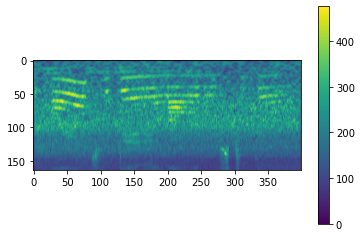

In [51]:
plt.figure()
test_cgram = image.cpu().numpy()
plt.imshow(test_cgram)
plt.colorbar()
plt.show()

# Compare Torch net to Ground truth labels
Also save the info on which examples the net gets correct/incorrect

In [ ]:
f_metadata = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META.npy", 'r')

In [ ]:
f_key = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META_key.npy", 'r')

In [ ]:
labels = []
for word in f_metadata['word']:
    idx = np.argwhere(f_key == word)
    if len(idx) == 0:
        labels.append(-1)
    else:
        labels.append(idx.item())
labels = np.array(labels)
labels += 1

In [ ]:
y_hats = []
corrects = []

with h5py.File(f"{engram_dir}PsychophysicsWord2017W_not_resampled.hdf5", 'r') as f_in:
    for ind in range(len(f_in['data'])):
        word, genre =net(torch.tensor(np.reshape( f_in['data'][ind],(164,400))))
        
        y_hat = int(torch.argmax(word))
        y_hats.append(y_hat)
        corrects.append(y_hat == labels[ind])

In [ ]:
# Save net predictions and mistakes to file
with open(f"{engram_dir}PsychophysicsWord2017W_net_performance.p", 'wb') as f:
    results = {
        'net_pred': np.array(y_hats),
        'net_mistakes': np.logical_not(corrects)
    }
    pickle.dump(results, f)

# Compare Predified-Net with Torch Net
The outputs should match at timestep 0 of the predified-net

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

checkpoints_dir = f'{engram_dir}hcnn/checkpoints/'
tensorboard_dir = f'{engram_dir}hcnn/tensorboard/'

In [ ]:
# Specify which predified network you want to test
from pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
PNetClass = PBranchedNetwork_AllSeparateHP
pnet_name = 'all'
p_layers = 'All Layers'

In [ ]:
# Torch network outputs from before
print(y_hats[:20])

In [ ]:
# Predified network outputs
pnet = PNetClass(net, build_graph=True)
pnet.load_state_dict(torch.load(
    f"{checkpoints_dir}{pnet_name}/{pnet_name}-50-regular.pth",
    map_location='cpu'
    ))
pnet.to(DEVICE)
pnet.build_graph = False        # only required for training
pnet.eval()

y_hats = []

f_in = h5py.File(f"{engram_dir}PsychophysicsWord2017W_not_resampled.hdf5", 'r')
for ind in range(len(f_in['data'])):
    pnet.reset()
    _input = torch.tensor(np.reshape(f_in['data'][ind],(164,400))).to(DEVICE)
    word, genre = pnet(_input)
    y_hat = int(torch.argmax(word))
    y_hats.append(y_hat)
    if len(y_hats) > 20:
        break
        
print(y_hats[:20])

# Test FF Torch Net on LargeNoisyData

In [3]:
from data.NoisyDataset import NoisyDataset, FullNoisyDataset, LargeNoisyDataset

In [4]:
# Torch network outputs
net = BranchedNetwork()
net.load_state_dict(torch.load(f'{engram_dir}networks_2022_weights.pt'))

y_hats = []

/share/issa/users/es3773/hallucnn/src/models/layers.py:78: UserWarning: Inconsistent tf pad calculation in ConvLayer.
  warnings.warn('Inconsistent tf pad calculation in ConvLayer.')
/share/issa/users/es3773/hallucnn/src/models/layers.py:173: UserWarning: Inconsistent tf pad calculation: 0, 1
  warnings.warn(f'Inconsistent tf pad calculation: {pad_left}, {pad_right}')


In [5]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net.to(DEVICE)

BranchedNetwork(
  (speech_branch): Sequential(
    (conv1): ConvLayer(
      (block): Sequential(
        (0): Conv2d(1, 96, kernel_size=(6, 14), stride=(3, 3), padding=(2, 6))
        (1): ReLU()
      )
    )
    (rnorm1): LRNorm(
      (block): LocalResponseNorm(5, alpha=0.005, beta=0.75, k=1.0)
    )
    (pool1): PoolLayer(
      (block): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (conv2): ConvLayer(
      (block): Sequential(
        (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 2))
        (1): ReLU()
      )
    )
    (rnorm2): LRNorm(
      (block): LocalResponseNorm(5, alpha=0.005, beta=0.75, k=1.0)
    )
    (pool2): PoolLayer(
      (block): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (conv3): ConvLayer(
      (block): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (conv4_W): ConvLayer(
   

In [43]:
noisy_ds = LargeNoisyDataset(bg='pinkNoise', snr=-9)
#noisy_ds = LargeNoisyDataset(bg='auditory_scene', snr=3)
#noisy_ds = NoisyDataset(bg='AudScene', snr=3)
noise_loader = torch.utils.data.DataLoader(
    noisy_ds,  batch_size=10,
    shuffle=True, drop_last=False,
    num_workers=2
    )

In [44]:
SCALING = 1

In [45]:
y_hats = []
ys = []
correct = 0
norms = []

for (images, labels) in noise_loader:
    for image in images:
        norms.append(np.linalg.norm(image*SCALING))
    images = images.cuda()
    labels = labels.cuda()
    images = images.squeeze()

    with torch.no_grad():
        outputs, _ = net(images*SCALING)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum()
        y_hats.extend(preds.tolist())
        ys.extend(labels.tolist())

In [46]:
ys

[17,
 174,
 107,
 349,
 202,
 467,
 4,
 372,
 436,
 407,
 292,
 416,
 434,
 127,
 69,
 48,
 456,
 156,
 235,
 147,
 404,
 441,
 435,
 522,
 213,
 484,
 12,
 219,
 215,
 83,
 291,
 92,
 522,
 4,
 417,
 111,
 492,
 252,
 68,
 402,
 515,
 160,
 411,
 340,
 391,
 486,
 388,
 364,
 368,
 365,
 513,
 270,
 85,
 264,
 154,
 503,
 516,
 157,
 394,
 522,
 437,
 272,
 453,
 151,
 337,
 173,
 428,
 112,
 110,
 226,
 71,
 337,
 12,
 368,
 356,
 107,
 410,
 448,
 316,
 360,
 314,
 427,
 42,
 251,
 65,
 432,
 331,
 313,
 507,
 453,
 493,
 443,
 159,
 145,
 447,
 45,
 188,
 372,
 518,
 102,
 436,
 237,
 425,
 374,
 260,
 53,
 411,
 60,
 375,
 404,
 45,
 523,
 271,
 24,
 372,
 277,
 332,
 408,
 421,
 243,
 354,
 313,
 370,
 501,
 35,
 399,
 19,
 391,
 237,
 132,
 348,
 99,
 262,
 78,
 418,
 432,
 509,
 109,
 281,
 347,
 492,
 25,
 123,
 245,
 469,
 7,
 221,
 190,
 160,
 524,
 26,
 430,
 361,
 176,
 368,
 88,
 428,
 169,
 221,
 16,
 156,
 185,
 319,
 253,
 121,
 5,
 477,
 37,
 324,
 129,
 46,
 339,
 14

In [47]:
off_by_p1 = np.sum(np.array(y_hats) == np.array(ys))
off_by_p1

1679

In [48]:
off_by_m1 = np.sum(np.array(y_hats) == np.array(ys)-2)
off_by_m1

11

In [49]:
not_off = np.sum(np.array(y_hats) == np.array(ys)-1)
not_off

19

In [50]:
np.max([off_by_p1, off_by_m1, not_off])/len(y_hats)

0.3358

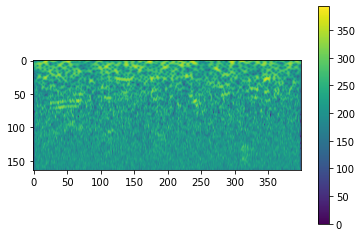

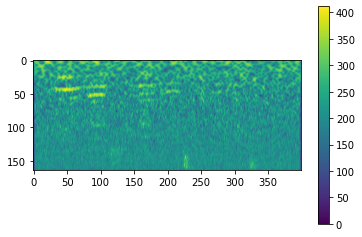

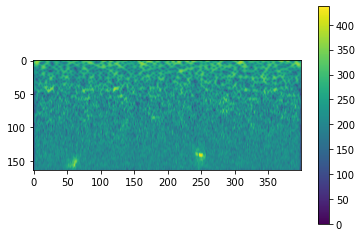

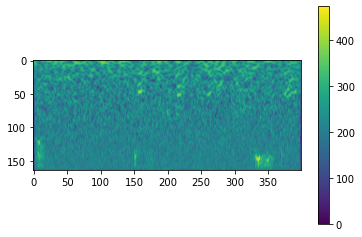

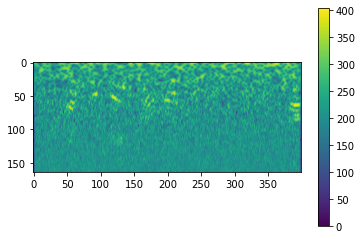

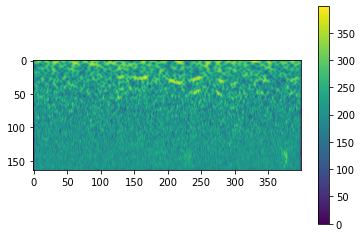

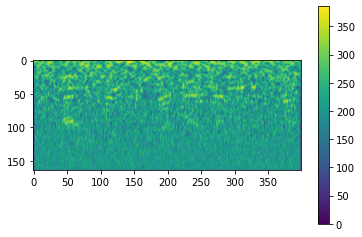

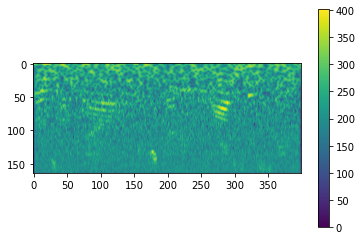

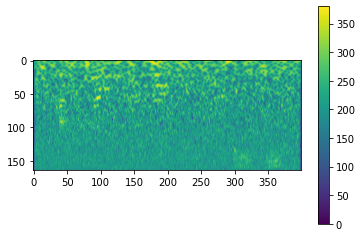

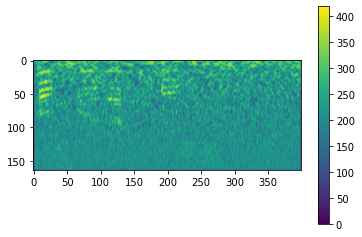

In [51]:
for image in images:
    plt.figure()
    test_cgram = image.cpu().numpy()
    plt.imshow(test_cgram*SCALING)
    plt.colorbar()
    plt.show()